# MITBIH

In [17]:
import pandas as pd
import os
import sys
import models
import types
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.mixture
from sklearn.metrics import roc_curve,precision_recall_curve,auc,accuracy_score,f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [18]:
def getScores(model_name,Y_test,pred_test,metrics_df):
    pred_test_temp = np.argmax(pred_test,axis=-1)
    Y_test_temp = np.argmax(Y_test,axis=-1)
    acc = accuracy_score(Y_test_temp, pred_test_temp)
    curr_metrics = {'Name': model_name,"ACC": acc}
    metrics_df = metrics_df.append(curr_metrics, ignore_index=True)
    return metrics_df

def visualize(df,title):
    plt.figure(figsize=(10,8))
    np.random.seed(0)
    n_sub_plots = 5
    for i in range(n_sub_plots):
        plt.subplot(n_sub_plots, 1, i + 1)
        plt.plot(df.iloc[np.random.choice(len(df[1])), :])
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(title)
    plt.show()

In [19]:
gpu = 0
lstm_out = 100
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

df_train = pd.read_csv("exercise_data/heartbeat/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("exercise_data/heartbeat/mitbih_test.csv", header=None)

# 87556 samples
Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(186))].values)[..., np.newaxis]
Y = keras.utils.to_categorical(Y)

# 21890 samples
Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(186))].values)[..., np.newaxis]
Y_test = keras.utils.to_categorical(Y_test)

# Visualize

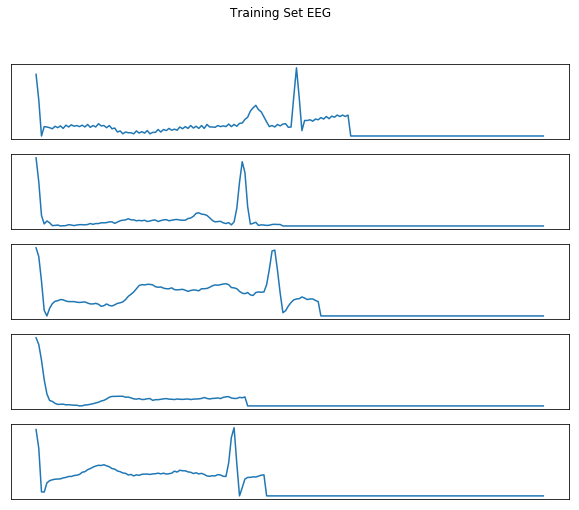

In [20]:
visualize(df_train, 'Training Set EEG')

# Models

In [21]:
metrics_df = pd.DataFrame(data=[],columns=['Name','ACC'])

models_ = [
    #sklearn.mixture.BayesianGaussianMixture(n_components=5),
    sklearn.mixture.GaussianMixture(n_components=5),
    RandomForestClassifier(n_jobs=-1),
    models.Residual_CNN(outputs=5, epochs=15),
    models.CNN_Model(outputs=5, epochs=15),
    models.LSTM_Model(outputs=5, epochs=15),
]

params = [
    #GMM
    {

    },
    # RandomForestClassifier
    {
        'n_estimators': [10, 100, 200],
        'n_jobs': [-1]
    },
    # Residual_CNN
    {
        'deepness': range(1, 6),
    },
    # CNN_Model
    {
        'conv1_size': [16, 32],
        'conv2_size': [32, 64],
        'conv3_size': [128, 256],
        'dense_size': [16, 32, 64],
    },
    # LSTM
    {
        'hidden': [64],
        'dense': [64],
    },
]

## Evaluate Models

In [22]:
model_preds = []
for param, model in zip(params, models_):
    clf = RandomizedSearchCV(model, param, cv=2,n_iter=3, verbose=2)
    if type(model) == RandomForestClassifier or \
        type(model) == sklearn.mixture.GaussianMixture or \
        type(model) == sklearn.mixture.BayesianGaussianMixture:
        clf.fit(np.squeeze(X), np.argmax(Y,axis=-1))
        model = clf.best_estimator_
        model.getScores = types.MethodType(models.CNN_Model.getScores_multi, model)
        _, metrics_df = model.getScores(np.squeeze(X_test), Y_test, metrics_df)
    else:
        clf.fit(X, Y)
        model = clf.best_estimator_
        pred, metrics_df = model.getScores_multi(X_test, Y_test, metrics_df)
        model_preds.append(pred)
    print(metrics_df)

/home/martin/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................
[CV] ................................................. , total=  51.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.2s remaining:    0.0s


[CV] ................................................. , total=  44.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min finished


              Name       ACC
0  GaussianMixture  0.451261
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_jobs=-1, n_estimators=10 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_jobs=-1, n_estimators=10, total=   2.1s
[CV] n_jobs=-1, n_estimators=10 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ....................... n_jobs=-1, n_estimators=10, total=   1.3s
[CV] n_jobs=-1, n_estimators=100 .....................................
[CV] ...................... n_jobs=-1, n_estimators=100, total=   8.8s
[CV] n_jobs=-1, n_estimators=100 .....................................
[CV] ...................... n_jobs=-1, n_estimators=100, total=   8.4s
[CV] n_jobs=-1, n_estimators=200 .....................................
[CV] ...................... n_jobs=-1, n_estimators=200, total=  16.9s
[CV] n_jobs=-1, n_estimators=200 .....................................
[CV] ...................... n_jobs=-1, n_estimators=200, total=  16.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.8s finished


                     Name       ACC
0         GaussianMixture  0.451261
1  RandomForestClassifier  0.974100
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] deepness=2 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 39399 samples, validate on 4378 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
39104/39399 [============================>.] - ETA: 0s - loss: 2.7471 - acc: 0.8294
Epoch 00001: val_acc improved from -inf to 0.82275, saving model to Residual_CNN.h5
39399/39399 [==============================] - 7s 172us/sample - loss: 2.7420 - acc: 0.8297 - val_loss: 2.8569 - val_acc: 0.8228
Epoch 2/15
39264/39399 [============================>.] - ETA: 0s - loss: 2.7405 - acc: 0.8300
Epoch 00002: val_acc did not improve from 0.82275
39399/39399 [==============================] - 5s 129us/sample - loss: 2.7426 - acc: 0.8298 - val_loss: 2.8569 - val_acc: 0.8228
Epoch 3/15
39360/39399 [============================>.] - ETA: 0s - loss: 2.7441 - acc: 0.8298
Epoch 00003: val_acc did not improve from 0.82275
39399/39399 [==============================] - 5s 130us/sample - loss: 2.7426 - acc: 0.8298 - val_loss: 2.8569 - val_acc: 0.8228
Epoch 4/15
39104/39399 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.0s remaining:    0.0s


[CV] deepness=2 ......................................................
Train on 39399 samples, validate on 4378 samples
Epoch 1/15
39136/39399 [============================>.] - ETA: 0s - loss: 2.7725 - acc: 0.8272
Epoch 00001: val_acc improved from -inf to 0.81247, saving model to Residual_CNN.h5
39399/39399 [==============================] - 7s 169us/sample - loss: 2.7732 - acc: 0.8272 - val_loss: 3.0226 - val_acc: 0.8125
Epoch 2/15
39296/39399 [============================>.] - ETA: 0s - loss: 2.7736 - acc: 0.8279
Epoch 00002: val_acc did not improve from 0.81247
39399/39399 [==============================] - 5s 129us/sample - loss: 2.7745 - acc: 0.8279 - val_loss: 3.0226 - val_acc: 0.8125
Epoch 3/15
39232/39399 [============================>.] - ETA: 0s - loss: 2.7756 - acc: 0.8278
Epoch 00003: val_acc did not improve from 0.81247
39399/39399 [==============================] - 5s 135us/sample - loss: 2.7745 - acc: 0.8279 - val_loss: 3.0226 - val_acc: 0.8125
Epoch 4/15
39072/39399 [

Epoch 14/15
39360/39399 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9773
Epoch 00014: val_acc did not improve from 0.96802
39399/39399 [==============================] - 5s 130us/sample - loss: 0.0845 - acc: 0.9772 - val_loss: 0.1130 - val_acc: 0.9676
Epoch 15/15
39072/39399 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9767
Epoch 00015: val_acc improved from 0.96802 to 0.96916, saving model to Residual_CNN.h5
43777/43777 [==============================] - 2s 37us/sample - loss: 0.0802 - acc: 0.9775
[CV] ....................................... deepness=5, total= 1.5min
[CV] deepness=1 ......................................................
Train on 39399 samples, validate on 4378 samples
Epoch 1/15
39168/39399 [============================>.] - ETA: 0s - loss: 0.2603 - acc: 0.9275
Epoch 00001: val_acc improved from -inf to 0.95180, saving model to Residual_CNN.h5
39399/39399 [==============================] - 7s 189us/sample - loss: 0.2597 - a

Epoch 9/15
39200/39399 [============================>.] - ETA: 0s - loss: 0.4075 - acc: 0.8597
Epoch 00009: val_acc did not improve from 0.94587
39399/39399 [==============================] - 5s 138us/sample - loss: 0.4074 - acc: 0.8598 - val_loss: 0.4367 - val_acc: 0.8497
Epoch 00009: early stopping
43777/43777 [==============================] - 2s 40us/sample - loss: 0.4094 - acc: 0.8590
[CV] ....................................... deepness=1, total=  56.4s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.8min finished


Train on 78798 samples, validate on 8756 samples
Epoch 1/15
78720/78798 [============================>.] - ETA: 0s - loss: 2.7623 - acc: 0.8285
Epoch 00001: val_acc improved from -inf to 0.82047, saving model to Residual_CNN.h5
78798/78798 [==============================] - 14s 181us/sample - loss: 2.7624 - acc: 0.8285 - val_loss: 2.8937 - val_acc: 0.8205
Epoch 2/15
78720/78798 [============================>.] - ETA: 0s - loss: 2.7629 - acc: 0.8286
Epoch 00002: val_acc did not improve from 0.82047
78798/78798 [==============================] - 11s 144us/sample - loss: 2.7637 - acc: 0.8285 - val_loss: 2.8937 - val_acc: 0.8205
Epoch 3/15
78624/78798 [============================>.] - ETA: 0s - loss: 2.7636 - acc: 0.8285
Epoch 00003: val_acc did not improve from 0.82047
78798/78798 [==============================] - 11s 144us/sample - loss: 2.7637 - acc: 0.8285 - val_loss: 2.8937 - val_acc: 0.8205
Epoch 4/15
78464/78798 [============================>.] - ETA: 0s - loss: 2.7635 - acc: 0.82

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] dense_size=32, conv3_size=128, conv2_size=32, conv1_size=32 .....
Train on 39399 samples, validate on 4378 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.4339 - acc: 0.8703
Epoch 00001: val_acc improved from -inf to 0.90978, saving model to CNN_Model.h5
39399/39399 [==============================] - 9s 235us/sample - loss: 0.4326 - acc: 0.8708 - val_loss: 0.3172 - val_acc: 0.9098
Epoch 2/15
39296/39399 [============================>.] - ETA: 0s - loss: 0.2710 - acc: 0.9260
Epoch 00002: val_acc improved from 0.90978 to 0.94221, saving model to CNN_Model.h5
39399/39399 [==============================] - 6s 146us/sample - loss: 0.2711 - acc: 0.9260 - val_loss: 0.2215 - val_acc: 0.9422
Epoch 3/15
39168/39399 [============================>.] - ETA: 0s - loss: 0.2209 - acc: 0.9396
Epoch 00003: val_acc improved from 0.94221 to 0.94884, saving model to CNN_Model.h5
39399/3939

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] dense_size=32, conv3_size=128, conv2_size=32, conv1_size=32 .....
Train on 39399 samples, validate on 4378 samples
Epoch 1/15
39072/39399 [============================>.] - ETA: 0s - loss: 0.4370 - acc: 0.8668
Epoch 00001: val_acc improved from -inf to 0.89698, saving model to CNN_Model.h5
39399/39399 [==============================] - 9s 237us/sample - loss: 0.4361 - acc: 0.8671 - val_loss: 0.3320 - val_acc: 0.8970
Epoch 2/15
39200/39399 [============================>.] - ETA: 0s - loss: 0.2932 - acc: 0.9143
Epoch 00002: val_acc improved from 0.89698 to 0.92873, saving model to CNN_Model.h5
39399/39399 [==============================] - 6s 150us/sample - loss: 0.2934 - acc: 0.9142 - val_loss: 0.2665 - val_acc: 0.9287
Epoch 3/15
39296/39399 [============================>.] - ETA: 0s - loss: 0.2451 - acc: 0.9303
Epoch 00003: val_acc improved from 0.92873 to 0.94038, saving model to CNN_Model.h5
39399/39399 [==============================] - 6s 149us/sample - loss: 0.2453 - acc: 0.9

Epoch 12/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9713
Epoch 00012: val_acc improved from 0.97396 to 0.97487, saving model to CNN_Model.h5
39399/39399 [==============================] - 6s 151us/sample - loss: 0.1046 - acc: 0.9713 - val_loss: 0.0945 - val_acc: 0.9749
Epoch 13/15
39136/39399 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9731
Epoch 00013: val_acc did not improve from 0.97487
39399/39399 [==============================] - 6s 151us/sample - loss: 0.1017 - acc: 0.9731 - val_loss: 0.0951 - val_acc: 0.9730
Epoch 14/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.0964 - acc: 0.9740
Epoch 00014: val_acc did not improve from 0.97487
39399/39399 [==============================] - 6s 151us/sample - loss: 0.0962 - acc: 0.9740 - val_loss: 0.1014 - val_acc: 0.9735
Epoch 15/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9743
Epoch 00015: val_acc improved from 0.97487 to

Epoch 7/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.1432 - acc: 0.9619
Epoch 00007: val_acc improved from 0.96528 to 0.96871, saving model to CNN_Model.h5
39399/39399 [==============================] - 6s 157us/sample - loss: 0.1430 - acc: 0.9620 - val_loss: 0.1291 - val_acc: 0.9687
Epoch 8/15
39104/39399 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9645
Epoch 00008: val_acc did not improve from 0.96871
39399/39399 [==============================] - 6s 156us/sample - loss: 0.1318 - acc: 0.9644 - val_loss: 0.1241 - val_acc: 0.9667
Epoch 9/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.1264 - acc: 0.9654
Epoch 00009: val_acc did not improve from 0.96871
39399/39399 [==============================] - 6s 156us/sample - loss: 0.1264 - acc: 0.9655 - val_loss: 0.1161 - val_acc: 0.9683
Epoch 10/15
39232/39399 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9682
Epoch 00010: val_acc improved from 0.96871 to 0.

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.3min finished


Train on 78798 samples, validate on 8756 samples
Epoch 1/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.4084 - acc: 0.8761
Epoch 00001: val_acc improved from -inf to 0.92736, saving model to CNN_Model.h5
78798/78798 [==============================] - 18s 235us/sample - loss: 0.4084 - acc: 0.8761 - val_loss: 0.2540 - val_acc: 0.9274
Epoch 2/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.2354 - acc: 0.9360
Epoch 00002: val_acc improved from 0.92736 to 0.95397, saving model to CNN_Model.h5
78798/78798 [==============================] - 13s 167us/sample - loss: 0.2353 - acc: 0.9360 - val_loss: 0.1774 - val_acc: 0.9540
Epoch 3/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9483
Epoch 00003: val_acc improved from 0.95397 to 0.95694, saving model to CNN_Model.h5
78798/78798 [==============================] - 13s 167us/sample - loss: 0.1890 - acc: 0.9483 - val_loss: 0.1551 - val_acc: 0.9569
Epoch 4/15
78752/78798 [===

/home/martin/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] hidden=64, dense=64 .............................................
Train on 39399 samples, validate on 4378 samples
Epoch 1/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.4337 - acc: 0.8861
Epoch 00001: val_acc improved from -inf to 0.93216, saving model to LSTM_Model.h5
39399/39399 [==============================] - 17s 439us/sample - loss: 0.4337 - acc: 0.8861 - val_loss: 0.2662 - val_acc: 0.9322
Epoch 2/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.2249 - acc: 0.9415
Epoch 00002: val_acc improved from 0.93216 to 0.94861, saving model to LSTM_Model.h5
39399/39399 [==============================] - 14s 349us/sample - loss: 0.2249 - acc: 0.9415 - val_loss: 0.1940 - val_acc: 0.9486
Epoch 3/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.1726 - acc: 0.9528
Epoch 00003: val_acc improved from 0.94861 to 0.95249, saving model to LSTM_Model.h5
39399/39399 [===========

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV] hidden=64, dense=64 .............................................
Train on 39399 samples, validate on 4378 samples
Epoch 1/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.5750 - acc: 0.8463
Epoch 00001: val_acc improved from -inf to 0.89470, saving model to LSTM_Model.h5
39399/39399 [==============================] - 18s 450us/sample - loss: 0.5749 - acc: 0.8463 - val_loss: 0.3903 - val_acc: 0.8947
Epoch 2/15
39392/39399 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.9269
Epoch 00002: val_acc improved from 0.89470 to 0.92759, saving model to LSTM_Model.h5
39399/39399 [==============================] - 14s 352us/sample - loss: 0.2909 - acc: 0.9269 - val_loss: 0.2677 - val_acc: 0.9276
Epoch 3/15
39360/39399 [============================>.] - ETA: 0s - loss: 0.2173 - acc: 0.9412
Epoch 00003: val_acc improved from 0.92759 to 0.94107, saving model to LSTM_Model.h5
39399/39399 [==============================] - 14s 353us/sample - loss: 0.2171 - ac

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.8min finished


Train on 78798 samples, validate on 8756 samples
Epoch 1/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.3397 - acc: 0.9100
Epoch 00001: val_acc improved from -inf to 0.94312, saving model to LSTM_Model.h5
78798/78798 [==============================] - 32s 410us/sample - loss: 0.3396 - acc: 0.9100 - val_loss: 0.2213 - val_acc: 0.9431
Epoch 2/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.1984 - acc: 0.9488
Epoch 00002: val_acc improved from 0.94312 to 0.95626, saving model to LSTM_Model.h5
78798/78798 [==============================] - 28s 358us/sample - loss: 0.1984 - acc: 0.9488 - val_loss: 0.1677 - val_acc: 0.9563
Epoch 3/15
78752/78798 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9583
Epoch 00003: val_acc improved from 0.95626 to 0.96574, saving model to LSTM_Model.h5
78798/78798 [==============================] - 28s 359us/sample - loss: 0.1525 - acc: 0.9583 - val_loss: 0.1225 - val_acc: 0.9657
Epoch 4/15
78752/78798 [

# Ensemble

In [23]:
model_preds = np.array(model_preds)
model_preds = np.squeeze(model_preds)

## Average predictions

In [24]:
avg_pred = np.mean(model_preds,axis=0)
metrics_df = getScores('Ensemble(Avg)',Y_test=Y_test,pred_test=avg_pred,metrics_df=metrics_df)

## Logistic Regression

In [25]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(n_jobs=-1,multi_class = 'multinomial',solver='lbfgs')
X_lg = np.transpose(model_preds,[1,2,0])
n_samples = X_lg.shape[0]
X_lg = np.reshape(X_lg,[n_samples,-1])
lg.fit(X_lg,np.argmax(Y_test,axis=-1))
lg_pred = lg.predict_proba(X_lg)
metrics_df = getScores('Ensemble(LG)',Y_test=Y_test,pred_test=lg_pred,metrics_df=metrics_df)

# Results

In [26]:
print(metrics_df)

                     Name       ACC
0         GaussianMixture  0.451261
1  RandomForestClassifier  0.974100
2            Residual_CNN  0.827608
3               CNN_Model  0.977343
4              LSTM_Model  0.980084
5           Ensemble(Avg)  0.976567
6            Ensemble(LG)  0.982414
